In [1]:
import numpy as np
import numpy.random as random
import torch
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('./model')
from pfnn_consist_2d import *
# from pfnn import *
from utilities import *

torch.manual_seed(0)
np.random.seed(0)

font = {'size': 16, 'family': 'Times New Roman'}
matplotlib.rc('font', **font)

This notebook contains code to visualize PFNN predictions on the Kolmogorov Flow. Additionally, the notebook can easily be adapted to visualizing predictions on other 2D Navier-Stokes equation systems.

In the mean time, we visualize the learned invariant statistics of long term predictions to the true invariant measure of the system.

## Preparation

In [2]:
# Use the custom load function to load your model
pfnn_path = './lake/models/your_model_path/model.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
model_pfnn = torch.load(pfnn_path, map_location=device)

In [3]:
# setup to load data
ntest = 100 # number of test trajectories
test_samples = 20 # number of samples from test set
S = 64 # size of image, also the domain size
T_in = 200 # skip first 100 steps of each trajectory to let trajectory reach attractor
T = 300 # seconds to extract from each trajectory in data
T_out = T_in + T

# load data
data = np.load('./lake/data/2D_NS_Re40.npy')
data = torch.tensor(data, dtype=torch.float)
data_sampled_test = data[torch.randperm(data[-ntest:].size(0))[:test_samples],...]
test_a = data_sampled_test[:,T_in-1:T_out-1].reshape(-1, S, S)
test_u = data_sampled_test[:,T_in:T_out].reshape(-1, S, S)


## Short-mid term prediction

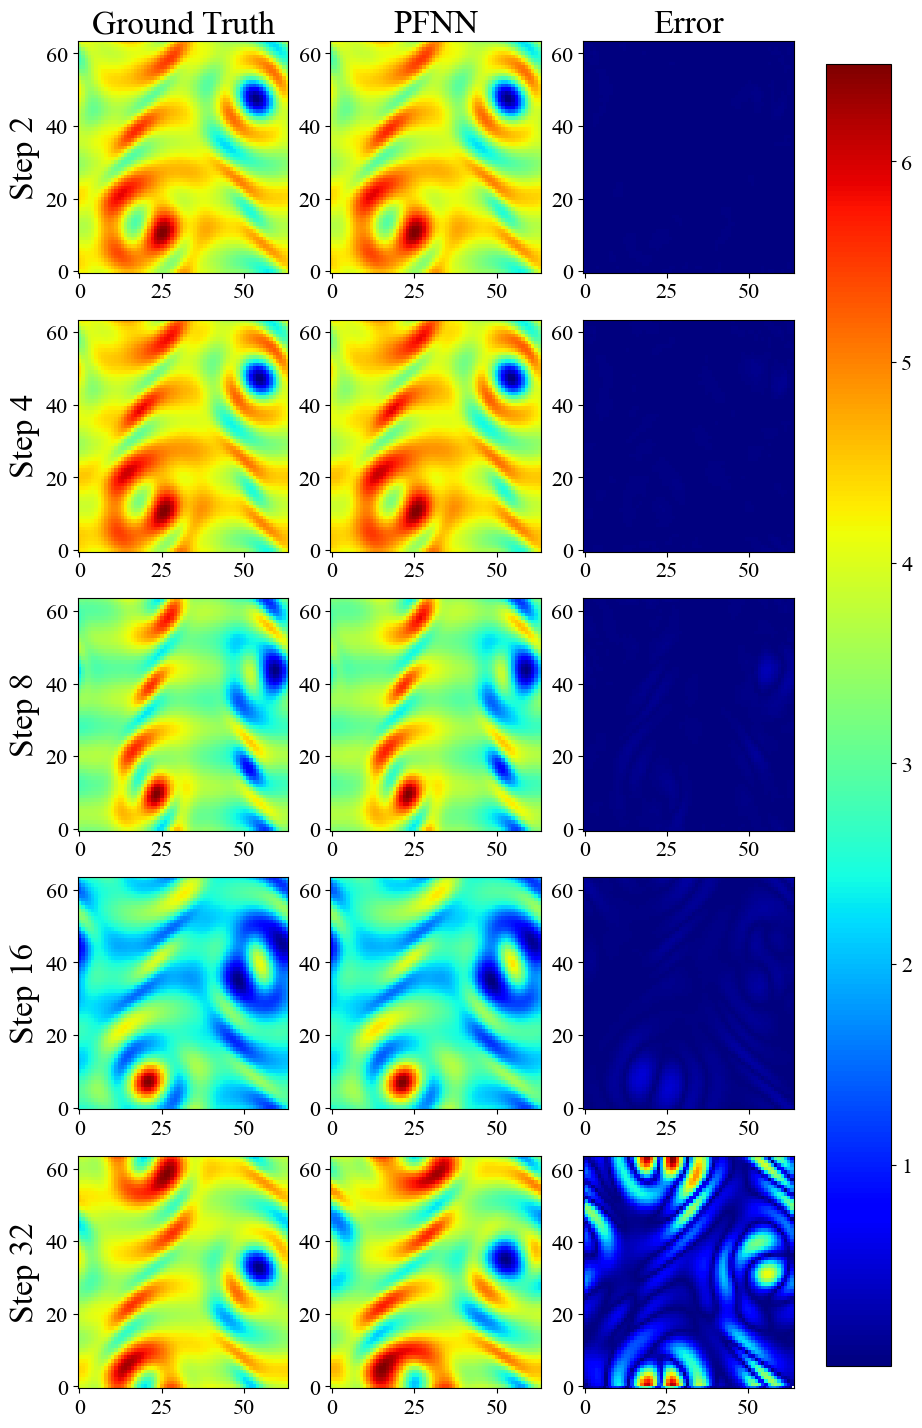

In [4]:
id = 10
test_a_0 = test_a[int(id*T)]

sample_ids = [2,4,8,16,32]
ground_truth = test_u[id*T:id*T+T][sample_ids]
pred_pfnn_sample = pred_traj_sample(model_pfnn, id, test_a, S, T)[sample_ids]
plot_sample_abs(ground_truth, pred_pfnn_sample, sample_id=sample_ids)

## Invariant Statistics

### Turbulent kinetic energy (TKE) and Mean State

In [5]:
def tke(u):
    mean_u = torch.mean(u, dim=0, keepdim=True)
    return torch.mean((u - mean_u.repeat(u.shape[0], 1, 1)) ** 2, dim=0), mean_u[0]

In [6]:
id = 10
# obtain ground truth TKE and mean state
tke_truth, mean_truth = tke(test_u[int(id*T):int((id+1)*T)])
# obtain TKE and mean state from PFNN prediction
pred_pfnn = pred_traj_sample(model_pfnn, id, test_a, S, T)
tke_pfnn, mean_pfnn = tke(pred_pfnn)
mean_diff_pfnn = torch.mean(abs(mean_pfnn - mean_truth))
abs_diff_pfnn = abs(tke_pfnn - tke_truth)


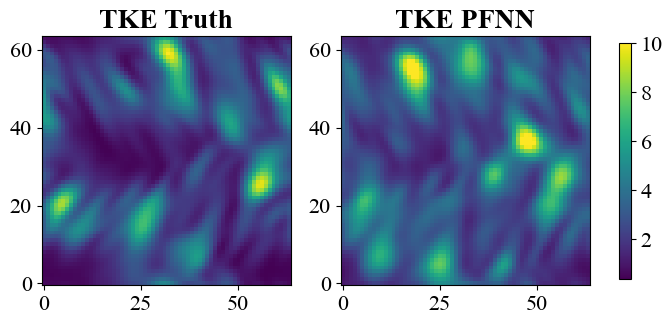

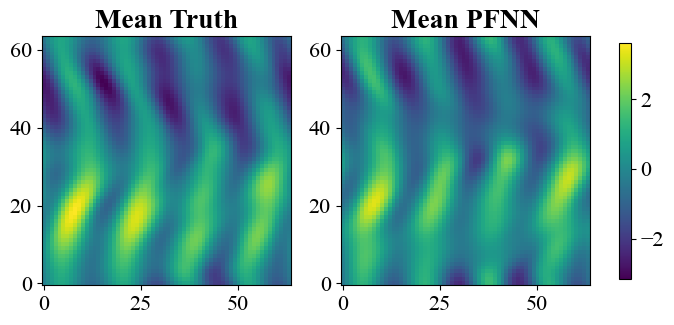

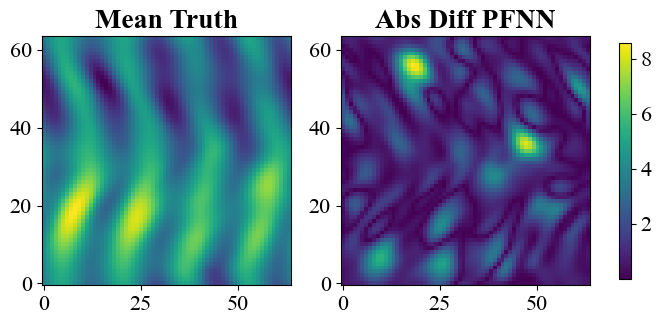

In [7]:
plot_comparison(
    tke_truth,
    [tke_pfnn],
    [mean_diff_pfnn],
    ['TKE Truth', 'TKE PFNN'],
    colorbase=None
)
plot_comparison(
      mean_truth,
      [mean_pfnn],
      [mean_diff_pfnn],
      ['Mean Truth', 'Mean PFNN'],
      colorbase=None
    )
plot_comparison(
      mean_truth,
      [abs_diff_pfnn],
      [mean_diff_pfnn],
      ['Mean Truth', 'Abs Diff PFNN'],
      colorbase=abs_diff_pfnn
    )